In [5]:
import os
import numpy as np
import pandas as pd
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split

# 定义数据路径
data_dir = r"C:\Users\admin\Desktop\weather"
label_file = os.path.join(data_dir, "weather_label.csv")

# 读取标签文件
labels_df = pd.read_csv(label_file)

# 自定义数据集类
class WeatherDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels_df.iloc[idx, 0])
        image = datasets.folder.default_loader(img_name)
        label = self.labels_df.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# 定义数据预处理
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载数据集
dataset = WeatherDataset(csv_file=label_file, root_dir=data_dir, transform=transform)

# 划分训练集和测试集
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class WeatherCNN(nn.Module):
    def __init__(self):
        super(WeatherCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = WeatherCNN()

In [7]:
import torch.optim as optim

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/10], Loss: 1.3638
Epoch [2/10], Loss: 1.0053
Epoch [3/10], Loss: 0.8463
Epoch [4/10], Loss: 0.6618
Epoch [5/10], Loss: 0.4759
Epoch [6/10], Loss: 0.2995
Epoch [7/10], Loss: 0.1718
Epoch [8/10], Loss: 0.0984
Epoch [9/10], Loss: 0.0823
Epoch [10/10], Loss: 0.0703


In [8]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

# 评估模型
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

# 计算评估指标
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.6267
Recall: 0.6267
F1 Score: 0.6266


In [9]:
# 使用预训练的ResNet模型
from torchvision.models import resnet18

resnet_model = resnet18(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 6)

# 训练和评估ResNet模型
# ...

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\admin/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [12:50<00:00, 60.8kB/s]


In [10]:
# 增加数据增强
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 重新加载数据集
dataset_augmented = WeatherDataset(csv_file=label_file, root_dir=data_dir, transform=transform_augmented)
train_dataset_augmented, test_dataset_augmented = random_split(dataset_augmented, [train_size, test_size])
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)
test_loader_augmented = DataLoader(test_dataset_augmented, batch_size=32, shuffle=False)

# 训练和评估增强后的数据集
# ...

In [11]:
# 重新训练模型
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader_augmented:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader_augmented):.4f}')

Epoch [1/10], Loss: 0.9168
Epoch [2/10], Loss: 0.7209
Epoch [3/10], Loss: 0.6145
Epoch [4/10], Loss: 0.5517
Epoch [5/10], Loss: 0.4668
Epoch [6/10], Loss: 0.4136
Epoch [7/10], Loss: 0.3681
Epoch [8/10], Loss: 0.3398
Epoch [9/10], Loss: 0.2812
Epoch [10/10], Loss: 0.2366


Accuracy: 0.7100
Recall: 0.7100
F1 Score: 0.7126


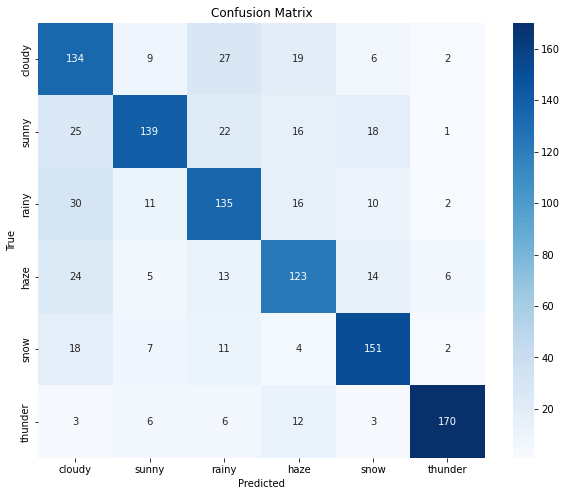

In [12]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 评估模型
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader_augmented:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

# 计算评估指标
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# 绘制混淆矩阵
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels_df['name'].unique(), yticklabels=labels_df['name'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
进一步优化模型

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 1.3968
Epoch [2/20], Loss: 1.1189
Epoch [3/20], Loss: 1.1143
Epoch [4/20], Loss: 1.0962
Epoch [5/20], Loss: 1.0199
Epoch [6/20], Loss: 0.9783
Epoch [7/20], Loss: 0.9759
Epoch [8/20], Loss: 0.9743
Epoch [9/20], Loss: 0.9439
Epoch [10/20], Loss: 0.9748
Epoch [11/20], Loss: 0.9188
Epoch [12/20], Loss: 1.0898
Epoch [13/20], Loss: 1.2554
Epoch [14/20], Loss: 1.1493
Epoch [15/20], Loss: 1.0559
Epoch [16/20], Loss: 0.9655
Epoch [17/20], Loss: 0.9369
Epoch [18/20], Loss: 0.9208
Epoch [19/20], Loss: 0.8912
Epoch [20/20], Loss: 0.8924
Accuracy: 0.6075
Recall: 0.6075
F1 Score: 0.6028


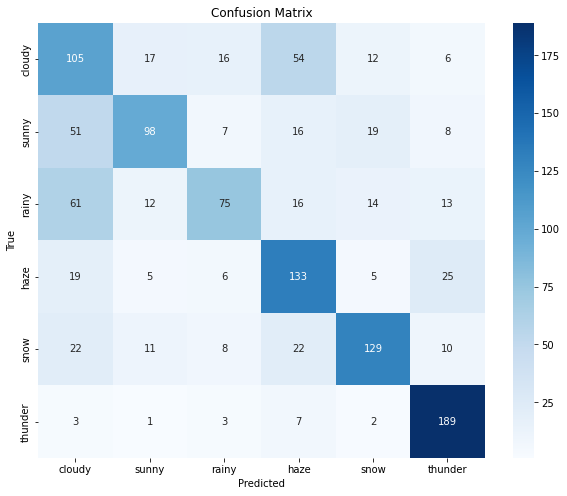

In [13]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.models import resnet18
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 定义数据路径
data_dir = r"C:\Users\admin\Desktop\weather"
label_file = os.path.join(data_dir, "weather_label.csv")

# 读取标签文件
labels_df = pd.read_csv(label_file)

# 自定义数据集类
class WeatherDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels_df.iloc[idx, 0])
        image = datasets.folder.default_loader(img_name)
        label = self.labels_df.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# 定义数据增强
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(64),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载数据集
dataset_augmented = WeatherDataset(csv_file=label_file, root_dir=data_dir, transform=transform_augmented)
train_size = int(0.8 * len(dataset_augmented))
test_size = len(dataset_augmented) - train_size
train_dataset_augmented, test_dataset_augmented = random_split(dataset_augmented, [train_size, test_size])
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)
test_loader_augmented = DataLoader(test_dataset_augmented, batch_size=32, shuffle=False)

# 使用预训练的ResNet模型
resnet_model = resnet18(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 6)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

# 训练模型
num_epochs = 20
for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader_augmented:
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader_augmented):.4f}')

# 评估模型
resnet_model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader_augmented:
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

# 计算评估指标
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# 绘制混淆矩阵
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels_df['name'].unique(), yticklabels=labels_df['name'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [14]:
from torch.optim.lr_scheduler import StepLR

# 定义学习率调度器
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# 训练模型
num_epochs = 20
for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader_augmented:
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader_augmented):.4f}')
    scheduler.step()

Epoch [1/20], Loss: 0.8958
Epoch [2/20], Loss: 0.8730
Epoch [3/20], Loss: 0.8561
Epoch [4/20], Loss: 0.8605
Epoch [5/20], Loss: 0.8347
Epoch [6/20], Loss: 0.7677
Epoch [7/20], Loss: 0.7369
Epoch [8/20], Loss: 0.7186
Epoch [9/20], Loss: 0.6916
Epoch [10/20], Loss: 0.6932
Epoch [11/20], Loss: 0.6857
Epoch [12/20], Loss: 0.6877
Epoch [13/20], Loss: 0.6716
Epoch [14/20], Loss: 0.6722
Epoch [15/20], Loss: 0.6767
Epoch [16/20], Loss: 0.6666
Epoch [17/20], Loss: 0.6817
Epoch [18/20], Loss: 0.6909
Epoch [19/20], Loss: 0.6798
Epoch [20/20], Loss: 0.6728


In [15]:
class WeatherCNN(nn.Module):
    def __init__(self):
        super(WeatherCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = WeatherCNN()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader_augmented:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader_augmented):.4f}')
    scheduler.step()

Epoch [1/20], Loss: 1.4048
Epoch [2/20], Loss: 1.3096
Epoch [3/20], Loss: 1.2842
Epoch [4/20], Loss: 1.2607
Epoch [5/20], Loss: 1.2191
Epoch [6/20], Loss: 1.2046
Epoch [7/20], Loss: 1.1840
Epoch [8/20], Loss: 1.1968
Epoch [9/20], Loss: 1.1777
Epoch [10/20], Loss: 1.1555
Epoch [11/20], Loss: 1.1568
Epoch [12/20], Loss: 1.1613
Epoch [13/20], Loss: 1.1363
Epoch [14/20], Loss: 1.1546
Epoch [15/20], Loss: 1.1086
Epoch [16/20], Loss: 1.0924
Epoch [17/20], Loss: 1.1210
Epoch [18/20], Loss: 1.1036
Epoch [19/20], Loss: 1.1111
Epoch [20/20], Loss: 1.0933


Accuracy: 0.7175
Recall: 0.7175
F1 Score: 0.7164


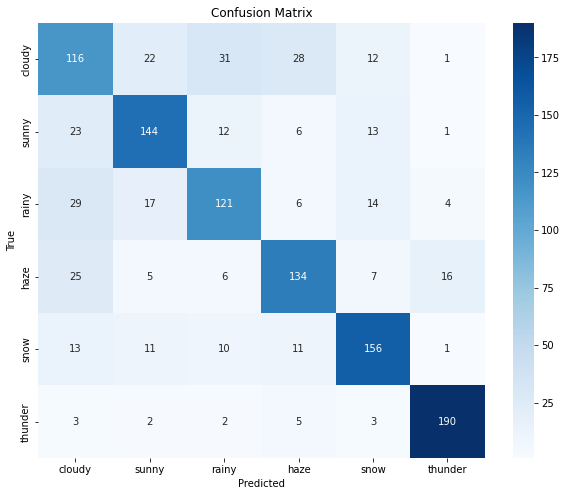

In [16]:
# 评估模型
resnet_model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader_augmented:
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

# 计算评估指标
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# 绘制混淆矩阵
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels_df['name'].unique(), yticklabels=labels_df['name'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()